Initialize

In [30]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "tensorflow"   # Must be called before importing keras
import keras
import torch
import tensorflow as tf
from scipy import stats
from imblearn.over_sampling import *
import warnings

warnings.filterwarnings("ignore")
seed = 123

# # Create requirements file
# pip list -format-freeze > requirements.txt

Import data and concatenate

In [32]:
outs = pl.read_excel("Data/Outcomes/outcomes.xlsx")
preds = pl.read_csv("Data/Predictors/Sleep(1).csv")
for i in range(9):
    temp = pl.read_csv(f"Data/Predictors/Sleep({i + 2}).csv")
    preds = pl.concat([preds, temp], how = "vertical")
preds = preds.rename({"Sleep Score 4 Weeks": "Date", "Score": "Sleep Score"})

# Retain only useful columns
preds = preds.select(pl.nth(0,1,2,3,5, 6, 7))

# Convert date column to date format
preds = preds.with_columns(
    (pl.col("Date") + " 2024")
    .str.strptime(pl.Date, format="%b %e %Y")
    .alias("Date"))

Merge factors and outcome on date

In [33]:
# Note: the predictors are mnissing data for 9/24/24 due to crossing the dateline.
df = preds.join(outs, how = "inner", on = "Date")

Convert temperature changes to numeric

In [34]:
df = df.with_columns(
    pl.col("Skin Temp Change").str.strip_chars_end("°").cast(pl.Float64))

EDA (other analysis done in VS Code extension)

<Axes: >

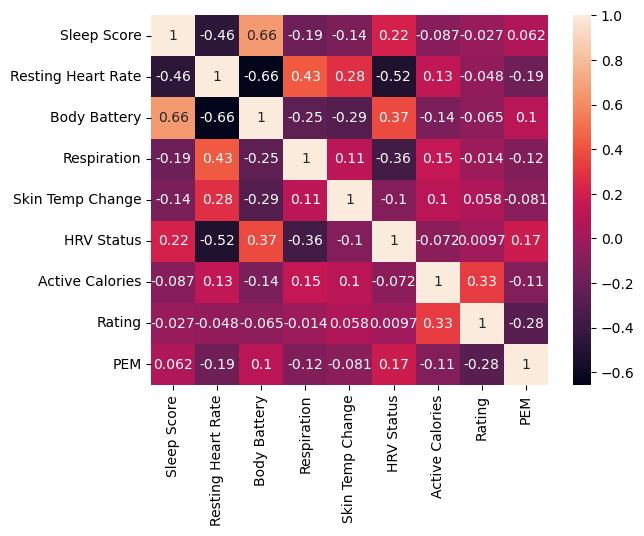

In [35]:
# Plot correlation matrix
sns.heatmap(df.to_pandas().iloc[:, 1:10].corr(), annot=True)

## Despite some collinearity, no variables appear duplicative.
## The low correlations between the outcomes and any other variable, including other outcomes,
    ## portend ill for the analysis' success.

Prep outcome column for ordinal classification

In [36]:
# Number of possible ratings
classes = 5

# Converting range of ratings to 0-based
df = df.with_columns((pl.col('Rating') - 1).alias('Rating'))

# Converting ratings to variation on one-hot encoding
y_matrix = np.zeros((len(df['Rating']), classes - 1))
for i in range(len(df['Rating'])):
    for j in range(classes - 1):
        y_matrix[i, j] = 1 if df['Rating'][i] > j else 0

# Adding new outcome columns to df (indexed as 10-13)
df = pl.concat([df, pl.from_numpy(y_matrix)], how = "horizontal")

Standardize and split data

In [37]:
scaler = StandardScaler()
dfp = df.to_pandas()
dfp.iloc[:, 1:7] = scaler.fit_transform(dfp.iloc[:, 1:7])

# Initial split between train, validation, and test sets
## Prioritizing training due to small dataset
dfp_train, dfp_test = train_test_split(dfp.iloc[:, 1:], test_size=0.3, random_state=seed)
dfp_test, dfp_val = train_test_split(dfp_test, test_size=0.5, random_state=seed)
X_val = dfp_val.iloc[:, 0:6]
y_val = dfp_val.iloc[:, 9:]
X_test = dfp_test.iloc[:, 0:6]
y_test = dfp_test.iloc[:, 9:]

y_test_orig = dfp_test.iloc[:, 7]  # Used in calculating metrics on test set

Balance training and validation data. Validation is balanced due to problems fitting models to low-frequency categories. A custom metric might be more appropriate, but my attempts failed.

In [38]:
# Split dfp into ratings and rest. Then split rest into predictors and outcome matrix
ros = RandomOverSampler(random_state=seed)  # Other techniques required a larger dataset.

X_train, y_train_ratings = ros.fit_resample(dfp_train.drop(dfp_train.columns[6], axis=1), dfp_train.iloc[:, 7])
y_train = X_train.iloc[:, -4:]
X_train = X_train.iloc[:, 0:6]

# Exactly same results when oversampling the validation set using two different seeds
# X_val, y_val_ratings = ros.fit_resample(dfp_val.drop(dfp_val.columns[6], axis=1), dfp_val.iloc[:, 7])
# y_val = X_val.iloc[:, -4:]
# X_val = X_val.iloc[:, 0:6]

Create ordinal classification model


In [39]:
## Each hyperparameter, including the metric, the number of layers and nodes, whether to use L2 regularization on each layer, 
## the batch size, the dropout rate, the learning rate, and the L2 penalty was determined through a manual grid search.

## The downside of the matrix approach is that a custom loss is not possible (for me and Claude, at least).

keras.utils.set_random_seed(seed)
input_shape = (6,)

# Set hyperparamters
batch = 40
nodes = 26
drop_rate = 0.5
learn = 0.001
# pen = 0.01  # Not used

model = keras.Sequential(
    [ keras.layers.Input(shape = input_shape),
        keras.layers.Dense(nodes, activation="relu", 
                           kernel_initializer = keras.initializers.HeNormal(), 
                           name = "layer1"),
        keras.layers.Dropout(drop_rate, name = "dropout1"),
        keras.layers.Dense(nodes, activation="relu", 
                           kernel_initializer = keras.initializers.HeNormal(), 
                           name = "layer2"),
        keras.layers.Dropout(drop_rate, name = "dropout2"),
        keras.layers.Dense(nodes, activation="relu",  
                           kernel_initializer = keras.initializers.HeNormal(), 
                           name = "layer3"),
        keras.layers.Dense(classes - 1, activation='sigmoid',
                           kernel_initializer = keras.initializers.HeNormal(), 
                           name = "output")]
                           )
# model.summary()  # Uncomment to print architecture on screen

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learn),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

callbacks = [keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=100, 
                                           restore_best_weights=True)]

results = model.fit(
    X_train, 
    y_train, 
    validation_data = (X_val, y_val), 
    epochs = 1000, 
    verbose = 0,
    callbacks=callbacks,
    batch_size = batch
    )

print(f'Best validation accuracy: {round(max(results.history['val_accuracy']), 3)}')

test_metrics = model.evaluate(X_test, y_test, return_dict = True, verbose = 0)
print(f'Test accuracy: {round(test_metrics['accuracy'], 3)}')

model.save("final_model_rating_classification.keras")  # save final model

Best validation accuracy: 1.0
Test accuracy: 1.0


Load saved model and make predictions

In [40]:
model_final = keras.saving.load_model("final_model_rating_classification.keras")  # reload best model, built with seed = 123
predictions = model_final.predict(X_test, verbose = 0) # make predictions

Plot training and validation loss and metric

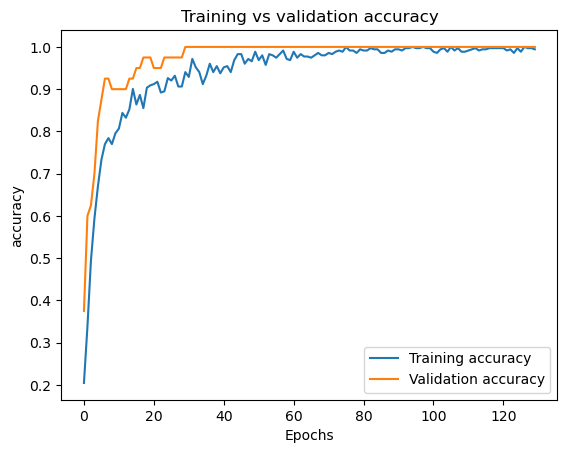

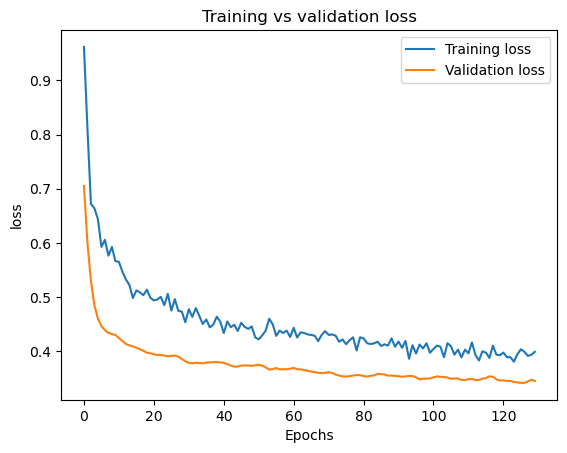

In [41]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.title(f'Training vs validation {metric}')
    plt.legend()
    plt.show()

# Plot accuracy
plot_metrics(results, 'accuracy')

# Plot loss
plot_metrics(results, 'loss')

Convert probability results to class predictions

In [42]:
# Convert predicted probabilities back to ordinal classes.
# Uses the first point where predictions drop below 0.5 as the class boundary.

n_samples = predictions.shape[0]
predictions_ordinal = np.zeros(n_samples)

for i in range(n_samples):
    # Find first threshold where probability drops below 0.5
    threshold_crossed = np.argmax(predictions[i] < 0.5)
    if threshold_crossed == 0 and predictions[i, 0] >= 0.5:   # If no threshold is crossed, assign highest class
        predictions_ordinal[i] = predictions.shape[1]
    else:
        predictions_ordinal[i] = threshold_crossed


Calculate accuracy metrics (omitting highest class due to NaN)

In [43]:
print("OVERALL ACCURACY")
print(f"Exact accuracy: {np.mean(y_test_orig == predictions_ordinal)}")
print(f'Accuracy within one: {np.sum(abs(y_test_orig - predictions_ordinal) <= 1) / len(predictions_ordinal)}')
print(f'MAE: {np.mean(abs(y_test_orig - predictions_ordinal))}')
print()
print("ACCURACY BY RATING")
print("Exact accuracy")
running = 0
for class_label in range(classes-1):
    class_mask = (y_test_orig == class_label)
    class_accuracy = np.mean(y_test_orig[class_mask] == predictions_ordinal[class_mask])
    running += class_accuracy
    print(f"Class {class_label} accuracy: {class_accuracy:.3f}")
print(f"Mean accuracy of equally weighted classes: {running/4:.3f}")

print()
print("Accuracy within one")
running = 0
for class_label in range(classes-1):
    class_mask = (y_test_orig == class_label)
    class_accuracy = np.mean(abs(y_test_orig[class_mask] - predictions_ordinal[class_mask]) <= 1)
    running += class_accuracy
    print(f"Class {class_label} accuracy: {class_accuracy:.3f}")
print(f"Mean accuracy-within-one of equally weighted classes: {running/4:.3f}")

print()
print(classification_report(y_test_orig, predictions_ordinal))

OVERALL ACCURACY
Exact accuracy: 0.475
Accuracy within one: 0.925
MAE: 0.6

ACCURACY BY RATING
Exact accuracy
Class 0 accuracy: 0.000
Class 1 accuracy: 0.929
Class 2 accuracy: 0.333
Class 3 accuracy: 0.000
Mean accuracy of equally weighted classes: 0.315

Accuracy within one
Class 0 accuracy: 1.000
Class 1 accuracy: 1.000
Class 2 accuracy: 1.000
Class 3 accuracy: 0.250
Mean accuracy-within-one of equally weighted classes: 0.812

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.41      0.93      0.57        14
           2       0.75      0.33      0.46        18
           3       0.00      0.00      0.00         4

    accuracy                           0.47        40
   macro avg       0.29      0.32      0.26        40
weighted avg       0.48      0.47      0.41        40



Checking correlation of predictions to actual results, using test set 

Correlation between observations and predictions: 0.28
Standard deviation of MAE: 0.624


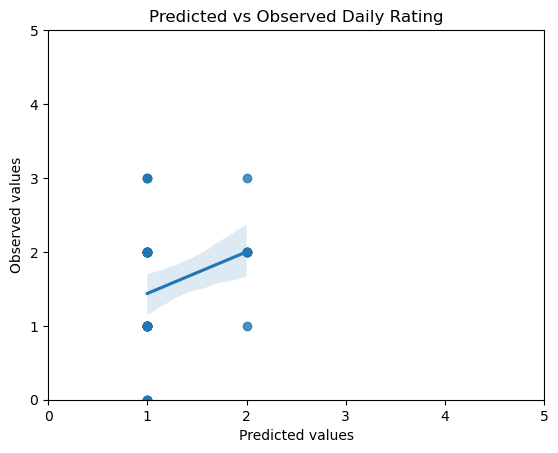

In [44]:
# Correlation and standard deviation of the errors
print(f'Correlation between observations and predictions: {round(np.corrcoef(y_test_orig, predictions_ordinal)[0][1], 3)}') 
print(f'Standard deviation of MAE: {round(np.std(np.absolute(np.subtract(y_test_orig, predictions_ordinal))), 3)}')

# Plotting lowess and linear regression lines, with 95% confidence interval for latter
sns.regplot(y = y_test_orig, x = predictions_ordinal)
plt.title('Predicted vs Observed Daily Rating')
plt.xlabel('Predicted values')
plt.ylabel('Observed values')
plt.xlim(0, 5)
plt.ylim(0,5)
plt.show()

**Discussion:** After finding the best hyperparameters and architecture with reference to two different seeds (123, 321), I then tested those hyperparameters using 10 other seeds (1-10) to identify the most promising hyperparameter/seed combination. Seed 123 was strongest. Then I calculated the test accuracy by running the best model using 10 different seeds (11-20) to split the data. (Two seeds produced splits without one of the classes, which skewed their accuracy metrics, so these were omitted, for a used total of 8.) I adopted this approach because all models reached 100% accuracy on the validation set, so I used the test-set performance to choose the best model. The use of different seeds was analogous to bagging. (Predictive performance on the full dataset was actually slightly worse.)

The average performance was calculated by a) using the overall accuracy and b) finding the accuracy for each class and then taking the average. a) Overall, the model predicted the correct rating on 52% of days and was close (within 1 rating point) on 95% of days. The MAE was 0.525 and its standard deviation was 0.566. However, this accuracy might be deceptive, since the vast majority of actual ratings were 1 or 2; thus, a model that simply predicts one of these at random might perform similarly well. Nonetheless, the correlation between the predicted and actual ratings was 0.31, which shows that the model, while imperfect, beats random guessing. b) Weighting each rating level equally is, for me, the more meaningful metric, as a person with ME would want to know whether the upcoming day will be especially good or bad. In this case, the model made accurate predictions 31% of the time and was close (no worse than one point away) 85% of the time.

In sum, the model is sufficiently suggestive to be 'not useless' - another imperfect source of information, but one that probably should outweigh its components, on which many people with ME currently rely. If this model is developed further, an important question would be whether to create a single model for all people with ME or to continually refine the base model here for each individual as they and their tracker produce more data. Finally, this model might be improved by preparing data to reflect gradual changes in baseline metrics. For example, today's resting heart rate per se might be less predictive than the difference between it and the average over the past ten days.
